In [2]:
# %load /Users/lzkelley/init.ipy
# Initialize Auto-Reloading Magic
%reload_ext autoreload
%autoreload 2

# Standard Imports
import os
import sys
import json
import copy
import shutil
import datetime
from collections import OrderedDict
from importlib import reload
import warnings

# Package Imports
import astropy as ap
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects

import sympy as sym
import sympy.physics
import sympy.physics.units as spu
from sympy.physics.units.systems import cgs
from sympy.physics.units import c, cm, g, s, km, gravitational_constant as G
pi = sym.pi

import h5py
import pandas as pd
import tqdm.notebook as tqdm
import corner

from zcode.constants import *
import zcode.plot as zplot
import zcode.math as zmath
import zcode.inout as zio
from zcode.inout.notebook import *
import zcode.astro as zastro

import kalepy as kale

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 12})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
plt.rcParams.update({'grid.alpha': 0.5})

sym.init_printing(use_latex='mathjax')


In [4]:
import cosmopy
reload(cosmopy)
cosmo = cosmopy.Cosmology()

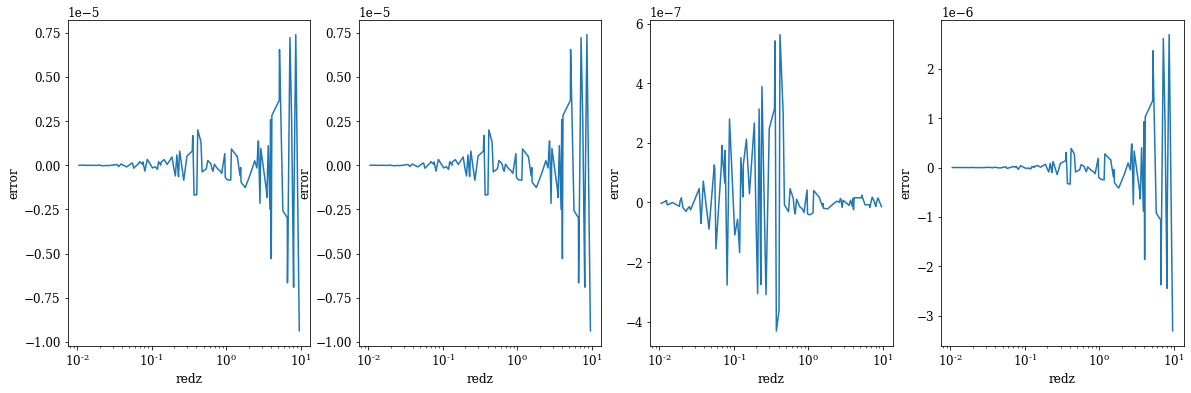

In [14]:
NUM = 100
redz = 10**np.random.uniform(-2, 1, int(NUM))
redz = sorted(redz)

funcs = ['tage', 'tlbk', 'dlum', 'dcom']
checks = ['age', 'lookback_time', 'luminosity_distance', 'comoving_distance']
funcs_for = ["z_to_" + ff for ff in funcs]
funcs_rev = [ff + "_to_z" for ff in funcs]

fig, axes = plt.subplots(figsize=[20, 6], ncols=len(funcs))

for ii, (ffor, frev) in enumerate(zip(funcs_for, funcs_rev)):
    val = getattr(cosmo, ffor)(redz)
    vz = getattr(cosmo, frev)(val)
    err = (vz - redz) / np.minimum(vz, redz)
    
    ax = axes[ii]
    ax.set(xscale='log', xlabel='redz', yscale='linear', ylabel='error')
    ax.plot(redz, err)
    
plt.show()


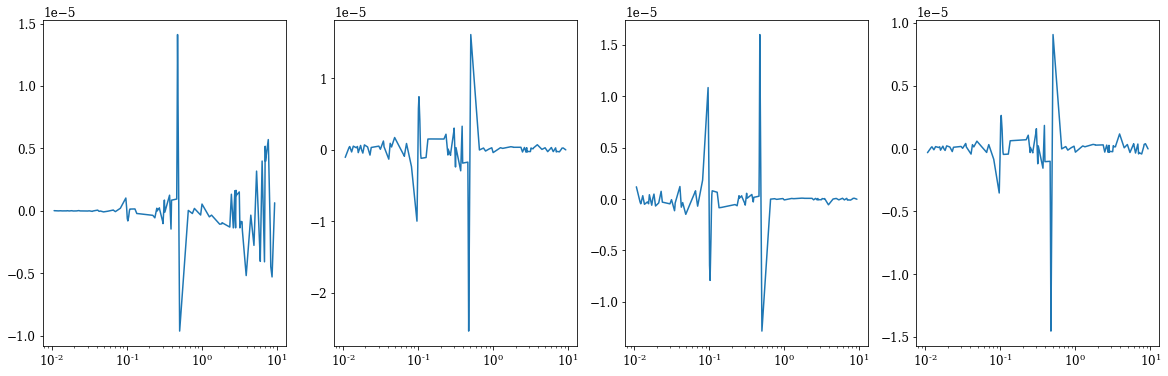

In [13]:
NUM = 100
redz = 10**np.random.uniform(-2, 1, int(NUM))
redz = np.sort(redz)

funcs = ['tage', 'tlbk', 'dlum', 'dcom']
funcs_check = ['age', 'lookback_time', 'luminosity_distance', 'comoving_distance']
funcs_for = ["z_to_" + ff for ff in funcs]
# funcs_rev = [ff + "_to_z" for ff in funcs]

fig, axes = plt.subplots(figsize=[20, 6], ncols=len(funcs))

for ii, (func, check) in enumerate(zip(funcs_for, funcs_check)):
    val = getattr(cosmo, func)(redz)
    chk = getattr(cosmo, check)(redz).cgs.value
    err = (val - chk) / np.minimum(chk, val)
    
    ax = axes[ii]
    ax.set(xscale='log', xlabel='redz', yscale='linear', ylabel='error')
    ax.plot(redz, err)
    
plt.show()
